# **Introduction**

**About Dataset**

* **Breast cancer** is one of the **most common** causes of death among **women worldwide**. Early detection helps in reducing the **number of early deaths**. The data reviews the **medical images of breast cancer** using ultrasound scan. **Breast Ultrasound Dataset** is categorized into **three classes** $:$ **normal, benign, and malignant images**. **Breast ultrasound images** can produce great results in **classification, detection, and segmentation** of breast cancer when combined with machine learning. 

* The data collected at baseline include **breast ultrasound images among women** in ages between 25 and 75 years old. This data was collected in **2018**. The number of patients is **600 female patients**. The dataset consists of **780 images** with an **average image size of 500*500 pixels**. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into **three classes, which are normal, benign, and malignant**.

**Approach**

* **Residual Attention UNet** is the best know model for **Multi-Class Segmentation**, thats why we will be creating a **Residual Attention UNet Model**.
* As the **image Dataset** is **old**, please **do not use it for any new medical operations**.
* All the images are of 500 X 500 pixels, **Kaggle RAM** wil not be enough so we will be resizing the Image to **256 X 256 pixels**.

**Model Architecture**

* The Model will consist of a **Residual Encoder Block, Residual Decoder Block and a Attention Gate.**

# **Imports**

In [1]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()

In [2]:
# common
import os
import time
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

# Data
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPooling2D, Conv2DTranspose
from keras.layers import Activation
from keras.layers import PReLU
from keras.layers import BatchNormalization

# Callbacks 
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# Metrics
from keras.metrics import MeanIoU

# **Data**

In [3]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]
    
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    
    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img
    
    return images

In [4]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [5]:
SIZE = 256

In [6]:
root_path = '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'
classes = sorted(os.listdir(root_path))
classes

['benign', 'malignant', 'normal']

In [7]:
single_mask_paths = sorted([sorted(glob(root_path + name + "/*mask.png")) for name in classes])
double_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_1.png")) for name in classes])

In [8]:
image_paths = []
mask_paths = []
for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)

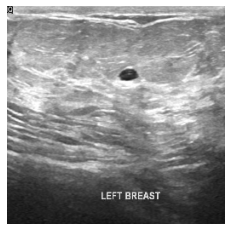

In [9]:
show_image(load_image(image_paths[0], SIZE))

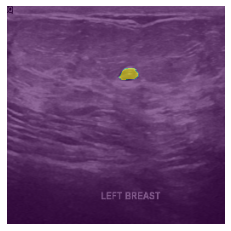

In [10]:
show_mask(load_image(image_paths[0], SIZE), load_image(mask_paths[0], SIZE)[:,:,0], alpha=0.6)

## **Approach**

Below here I have explained my strategy to tackel the multiple mask Images.

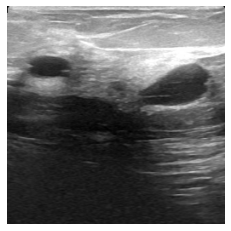

In [11]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))

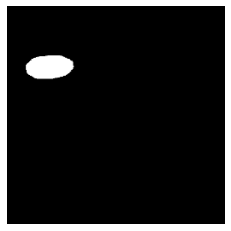

In [12]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE))

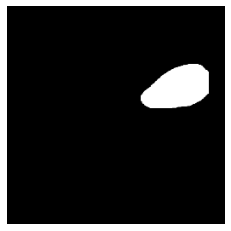

In [13]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE))

I don't want the data this way, as both the masks belongs to the same class. A better idea can be to merge both these images

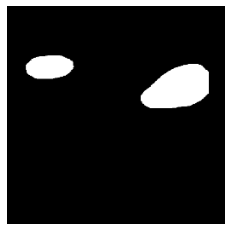

In [14]:
img = np.zeros((1,SIZE,SIZE,3))
mask1 = load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE)
mask2 = load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE)

img = img + mask1 + mask2
img = img[0,:,:,0]
show_image(img, cmap='gray')

We first merged them and them simple used the 1st channel because that is enough.

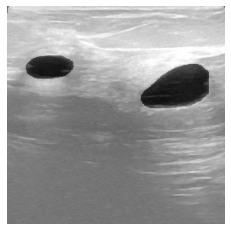

In [15]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, cmap='binary', alpha=0.4)
plt.axis('off')
plt.show()

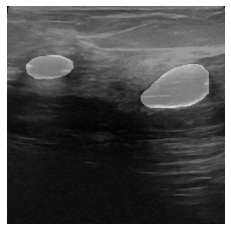

In [16]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, cmap='gray', alpha=0.4)
plt.axis('off')
plt.show()

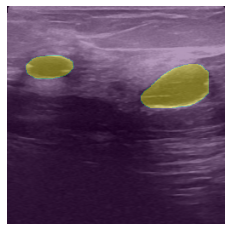

In [17]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, alpha=0.4)
plt.axis('off')
plt.show()

This is how it looks with different cmaps. But you can drop them as then are very less in number (i.e 16) and this will not affect training much.

## **Data Work**

In [18]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

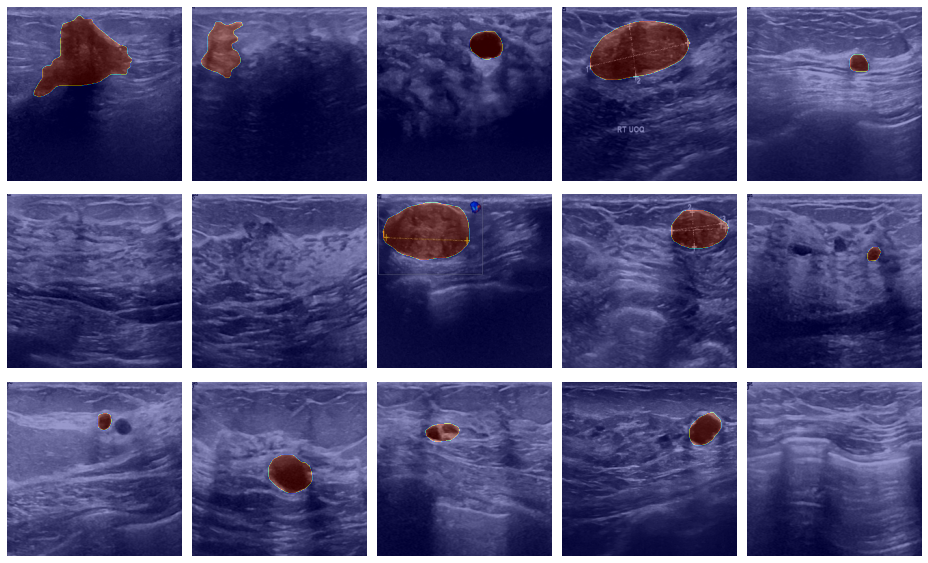

In [19]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='jet')
plt.tight_layout()
plt.show()

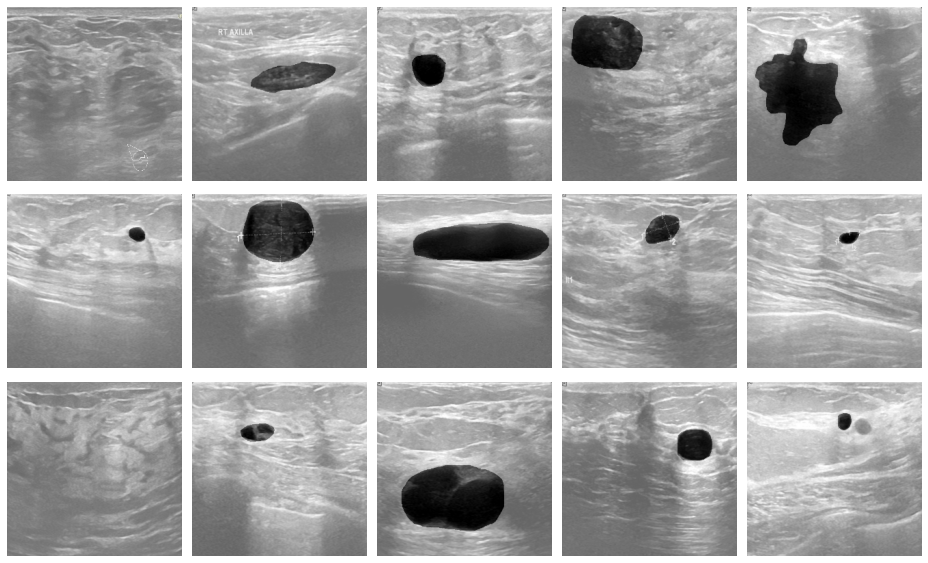

In [20]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='binary')
plt.tight_layout()
plt.show()

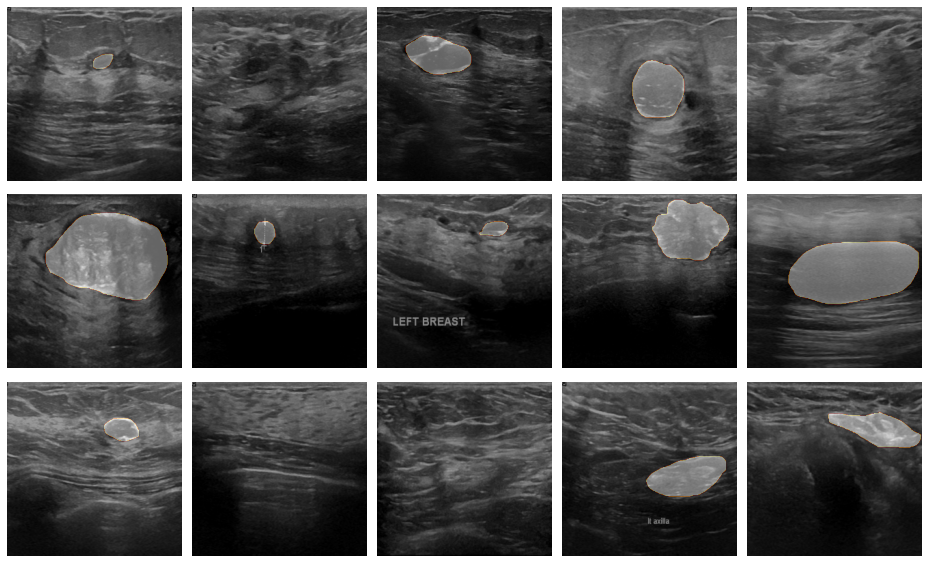

In [21]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='afmhot')
plt.tight_layout()
plt.show()

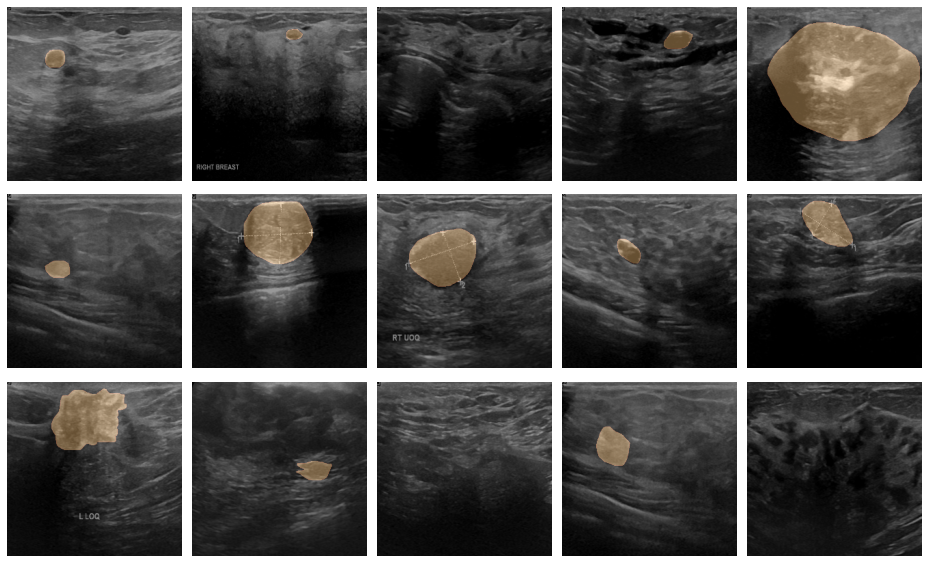

In [22]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='copper')
plt.tight_layout()
plt.show()

# **Encoder**

In [23]:
class EncoderBlock(Layer):
    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.drop = Dropout(rate)
        self.pool = MaxPooling2D(pool_size=(2, 2))
        self.res = ResidualBlock(filters)
        
    def call(self, X):
        x = self.res(X)
        #x = self.drop(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

# **Residual Block**

In [24]:
from keras.layers import ReLU
class ResidualBlock(Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.filters = filters
        
        self.c1 = Conv2D(self.filters, kernel_size=3, strides=1, padding='same')
        self.b1 = BatchNormalization()
        self.r1 = ReLU()
        
        self.c2 = Conv2D(self.filters, kernel_size=3, strides=1, padding='same')
        self.b2 = BatchNormalization()
        
        self.c3 = Conv2D(self.filters,(1,1), padding='same', strides=(1,1))
        self.r2 = ReLU()
        
    def call(self, X):
        out = self.c1(X)
        out = self.b1(out)
        out = self.r1(out)
        
        out = self.c2(out)
        out = self.b2(out)
        
        if X.get_shape()[-1] != out.get_shape()[-1]:
            X = self.c3(X)
            
        out = Add()([X, out])
        out = self.r2(out)

        return out
    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

# **Decoder**

In [25]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D((2, 2))
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

# **Attention Gate**

In [26]:
class AttentionGate(Layer):

    def __init__(self, filters, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)
        self.filters = filters

        self.normal = Conv2D(filters, kernel_size=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=1, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.one = Conv2D(1,(1,1),(1,1), padding="same")
        
        self.relu = Activation('relu')
        self.sigmoid = Activation('sigmoid')
        
        self.learn = Conv2D(filters, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D((2,2))
        

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        
        x = self.relu(x)
        x = self.one(x)
        x = self.sigmoid(x)
        
        x = self.resample(x)
        x = self.learn(x)
        f = Multiply()([x, skip_X])
        
        return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters
        }

# **Custom Callback**

In [27]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        if epochs % 10 == 0:
            id = np.random.randint(200)
            exp = GradCAM()
            image = images[id]
            mask = masks[id]
            pred_mask = self.model.predict(image[np.newaxis,...])
            cam = exp.explain(
                validation_data=(image[np.newaxis,...], mask),
                class_index=1,
                layer_name='Attention4',
                model=self.model
            )

            plt.figure(figsize=(10,5))

            plt.subplot(1,3,1)
            plt.title("Original Mask")
            show_mask(image, mask, cmap='copper')

            plt.subplot(1,3,2)
            plt.title("Predicted Mask")
            show_mask(image, pred_mask, cmap='copper')

            plt.subplot(1,3,3)
            show_image(cam,title="GradCAM")

            plt.tight_layout()
            plt.show()

# **Attention UNet**

In [28]:
from tensorflow.keras.optimizers import Adam
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # Inputs
    input_layer = Input(shape=images.shape[-3:])

    # Encoder
    p1, c1 = EncoderBlock(64,0.1, name="Encoder1")(input_layer)
    p2, c2 = EncoderBlock(128,0.1, name="Encoder2")(p1)
    p3, c3 = EncoderBlock(256,0.2, name="Encoder3")(p2)
    p4, c4 = EncoderBlock(512,0.2, name="Encoder4")(p3)

    # Encoding
    encoding = EncoderBlock(1024,0.3, pooling=False, name="Encoding")(p4)

    # Attention + Decoder

    a1 = AttentionGate(512, name="Attention1")([encoding, c4])
    d1 = DecoderBlock(512,0.2, name="Decoder1")([encoding, a1])

    a2 = AttentionGate(256, name="Attention2")([d1, c3])
    d2 = DecoderBlock(256,0.2, name="Decoder2")([d1, a2])

    a3 = AttentionGate(128, name="Attention3")([d2, c2])
    d3 = DecoderBlock(128,0.1, name="Decoder3")([d2, a3])


    a4 = AttentionGate(64, name="Attention4")([d3, c1])
    d4 = DecoderBlock(64,0.1, name="Decoder4")([d3, a4])

    # Output 
    output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

    # Model
    model = Model(
        inputs=[input_layer],
        outputs=[output_layer]
    )
    model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
    metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
    )

# Callbacks
cb = [
    # EarlyStopping(patience=3, restore_best_weights=True), # With Segmentation I trust on eyes rather than on metrics
    ModelCheckpoint("AttentionCustomUNet.h5", save_best_only=True, monitor='val_loss'),
    ShowProgress()
]
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Encoder1 (EncoderBlock)         ((None, 128, 128, 64 39488       input_1[0][0]                    
__________________________________________________________________________________________________
Encoder2 (EncoderBlock)         ((None, 64, 64, 128) 230784      Encoder1[0][0]                   
__________________________________________________________________________________________________
Encoder3 (EncoderBlock)         ((None, 32, 32, 256) 920320      Encoder2[0][0]                   
______________________________________________________________________________________________

# **Training**

In [30]:
model.load_weights("/kaggle/working/AttentionCustomUNet.h5")

Epoch 1/150
97/97 [==============================] - 68s 494ms/step - loss: 0.1046 - accuracy: 0.9594 - IoU: 0.4531 - val_loss: 0.0981 - val_accuracy: 0.9659 - val_IoU: 0.4909


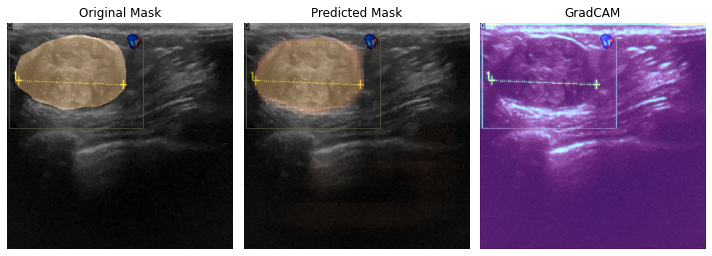

Epoch 2/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0816 - accuracy: 0.9684 - IoU: 0.4570 - val_loss: 0.0598 - val_accuracy: 0.9808 - val_IoU: 0.4909
Epoch 3/150
97/97 [==============================] - 42s 431ms/step - loss: 0.0782 - accuracy: 0.9683 - IoU: 0.4546 - val_loss: 0.0547 - val_accuracy: 0.9827 - val_IoU: 0.4909
Epoch 4/150
97/97 [==============================] - 42s 432ms/step - loss: 0.0642 - accuracy: 0.9737 - IoU: 0.4556 - val_loss: 0.0683 - val_accuracy: 0.9788 - val_IoU: 0.4909
Epoch 5/150
97/97 [==============================] - 42s 432ms/step - loss: 0.0559 - accuracy: 0.9770 - IoU: 0.4567 - val_loss: 0.1689 - val_accuracy: 0.9370 - val_IoU: 0.4909
Epoch 6/150
97/97 [==============================] - 42s 431ms/step - loss: 0.0540 - accuracy: 0.9774 - IoU: 0.4564 - val_loss: 0.0816 - val_accuracy: 0.9722 - val_IoU: 0.4958
Epoch 7/150
97/97 [==============================] - 42s 432ms/step - loss: 0.0579 - accuracy: 0.9766 - IoU: 0.4564 - va

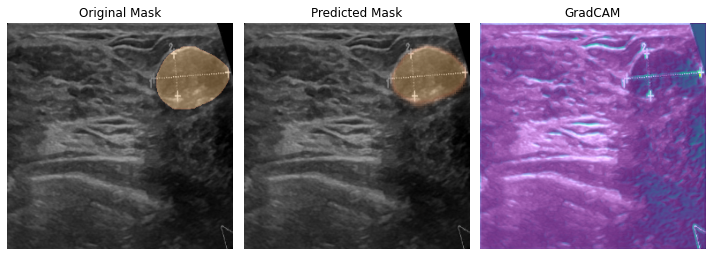

Epoch 12/150
97/97 [==============================] - 42s 432ms/step - loss: 0.0308 - accuracy: 0.9863 - IoU: 0.4580 - val_loss: 0.0804 - val_accuracy: 0.9779 - val_IoU: 0.4921
Epoch 13/150
97/97 [==============================] - 42s 431ms/step - loss: 0.0283 - accuracy: 0.9869 - IoU: 0.4655 - val_loss: 0.0808 - val_accuracy: 0.9795 - val_IoU: 0.4921
Epoch 14/150
97/97 [==============================] - 42s 431ms/step - loss: 0.0224 - accuracy: 0.9893 - IoU: 0.4719 - val_loss: 0.0933 - val_accuracy: 0.9805 - val_IoU: 0.4909
Epoch 15/150
97/97 [==============================] - 42s 431ms/step - loss: 0.0235 - accuracy: 0.9893 - IoU: 0.4712 - val_loss: 0.0832 - val_accuracy: 0.9756 - val_IoU: 0.4909
Epoch 16/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0218 - accuracy: 0.9896 - IoU: 0.4769 - val_loss: 0.0750 - val_accuracy: 0.9817 - val_IoU: 0.4912
Epoch 17/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0180 - accuracy: 0.9912 - IoU: 0.469

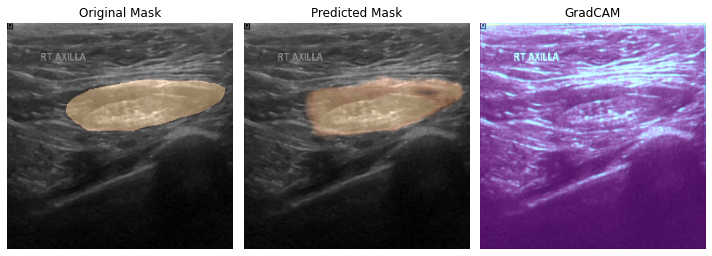

Epoch 22/150
97/97 [==============================] - 42s 431ms/step - loss: 0.0290 - accuracy: 0.9874 - IoU: 0.4749 - val_loss: 0.0956 - val_accuracy: 0.9814 - val_IoU: 0.4909
Epoch 23/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0255 - accuracy: 0.9884 - IoU: 0.4788 - val_loss: 0.1318 - val_accuracy: 0.9636 - val_IoU: 0.4976
Epoch 24/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0175 - accuracy: 0.9914 - IoU: 0.4674 - val_loss: 0.0933 - val_accuracy: 0.9808 - val_IoU: 0.4909
Epoch 25/150
97/97 [==============================] - 42s 431ms/step - loss: 0.0182 - accuracy: 0.9915 - IoU: 0.4772 - val_loss: 0.0999 - val_accuracy: 0.9736 - val_IoU: 0.4935
Epoch 26/150
97/97 [==============================] - 42s 431ms/step - loss: 0.0160 - accuracy: 0.9923 - IoU: 0.4758 - val_loss: 0.0875 - val_accuracy: 0.9814 - val_IoU: 0.4941
Epoch 27/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0115 - accuracy: 0.9936 - IoU: 0.486

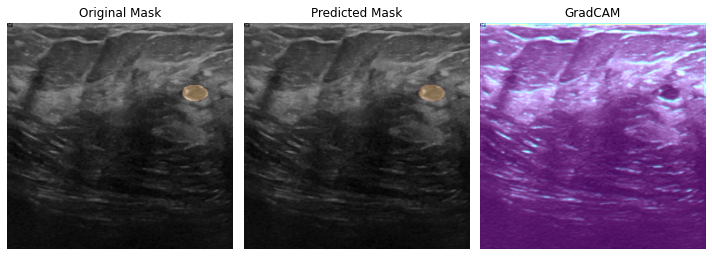

Epoch 32/150
97/97 [==============================] - 42s 432ms/step - loss: 0.0080 - accuracy: 0.9950 - IoU: 0.5228 - val_loss: 0.1087 - val_accuracy: 0.9831 - val_IoU: 0.5030
Epoch 33/150
97/97 [==============================] - 42s 431ms/step - loss: 0.0067 - accuracy: 0.9956 - IoU: 0.5334 - val_loss: 0.1196 - val_accuracy: 0.9809 - val_IoU: 0.5176
Epoch 34/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0072 - accuracy: 0.9954 - IoU: 0.5332 - val_loss: 0.1088 - val_accuracy: 0.9827 - val_IoU: 0.4921
Epoch 35/150
97/97 [==============================] - 42s 432ms/step - loss: 0.0074 - accuracy: 0.9954 - IoU: 0.5102 - val_loss: 0.1148 - val_accuracy: 0.9814 - val_IoU: 0.4999
Epoch 36/150
97/97 [==============================] - 42s 431ms/step - loss: 0.0084 - accuracy: 0.9951 - IoU: 0.5238 - val_loss: 0.0964 - val_accuracy: 0.9806 - val_IoU: 0.4947
Epoch 37/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0072 - accuracy: 0.9954 - IoU: 0.502

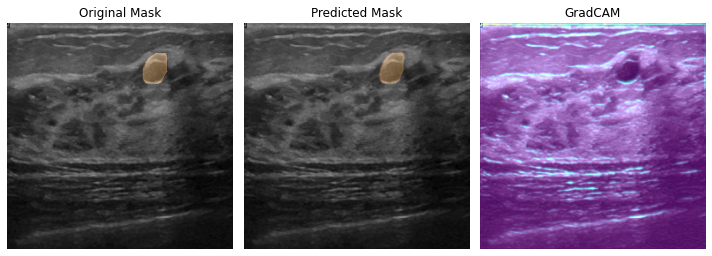

Epoch 42/150
97/97 [==============================] - 42s 431ms/step - loss: 0.0062 - accuracy: 0.9957 - IoU: 0.5599 - val_loss: 0.1379 - val_accuracy: 0.9762 - val_IoU: 0.5229
Epoch 43/150
97/97 [==============================] - 42s 431ms/step - loss: 0.0054 - accuracy: 0.9961 - IoU: 0.5563 - val_loss: 0.1276 - val_accuracy: 0.9788 - val_IoU: 0.5149
Epoch 44/150
97/97 [==============================] - 42s 431ms/step - loss: 0.0056 - accuracy: 0.9961 - IoU: 0.5730 - val_loss: 0.1265 - val_accuracy: 0.9801 - val_IoU: 0.5257
Epoch 45/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0051 - accuracy: 0.9963 - IoU: 0.5883 - val_loss: 0.1246 - val_accuracy: 0.9807 - val_IoU: 0.5398
Epoch 46/150
97/97 [==============================] - 42s 431ms/step - loss: 0.0465 - accuracy: 0.9819 - IoU: 0.5170 - val_loss: 0.4826 - val_accuracy: 0.7637 - val_IoU: 0.4909
Epoch 47/150
97/97 [==============================] - 42s 429ms/step - loss: 0.0695 - accuracy: 0.9730 - IoU: 0.455

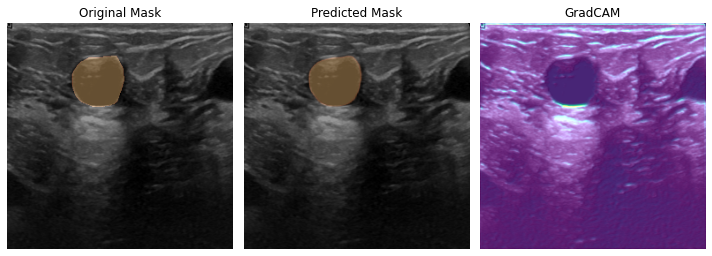

Epoch 52/150
97/97 [==============================] - 42s 428ms/step - loss: 0.0075 - accuracy: 0.9955 - IoU: 0.5020 - val_loss: 0.0933 - val_accuracy: 0.9837 - val_IoU: 0.4950
Epoch 53/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0073 - accuracy: 0.9955 - IoU: 0.4883 - val_loss: 0.1038 - val_accuracy: 0.9813 - val_IoU: 0.4919
Epoch 54/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0063 - accuracy: 0.9957 - IoU: 0.4913 - val_loss: 0.1132 - val_accuracy: 0.9792 - val_IoU: 0.5021
Epoch 55/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0052 - accuracy: 0.9962 - IoU: 0.5269 - val_loss: 0.1126 - val_accuracy: 0.9822 - val_IoU: 0.5046
Epoch 56/150
97/97 [==============================] - 42s 429ms/step - loss: 0.0048 - accuracy: 0.9964 - IoU: 0.5494 - val_loss: 0.1115 - val_accuracy: 0.9830 - val_IoU: 0.5057
Epoch 57/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0055 - accuracy: 0.9961 - IoU: 0.543

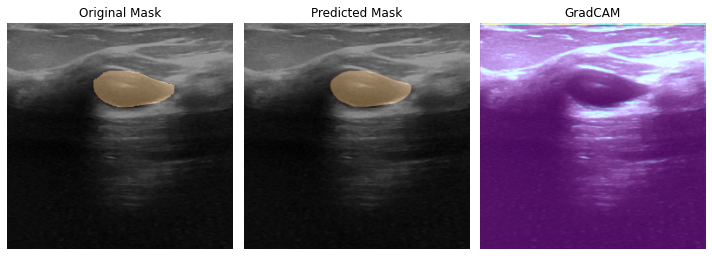

Epoch 62/150
97/97 [==============================] - 42s 429ms/step - loss: 0.0052 - accuracy: 0.9962 - IoU: 0.5699 - val_loss: 0.1122 - val_accuracy: 0.9841 - val_IoU: 0.5145
Epoch 63/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0067 - accuracy: 0.9960 - IoU: 0.5448 - val_loss: 0.1348 - val_accuracy: 0.9656 - val_IoU: 0.4909
Epoch 64/150
97/97 [==============================] - 42s 429ms/step - loss: 0.0066 - accuracy: 0.9958 - IoU: 0.4548 - val_loss: 0.1060 - val_accuracy: 0.9818 - val_IoU: 0.4909
Epoch 65/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0048 - accuracy: 0.9964 - IoU: 0.4581 - val_loss: 0.1143 - val_accuracy: 0.9826 - val_IoU: 0.4910
Epoch 66/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0042 - accuracy: 0.9966 - IoU: 0.4719 - val_loss: 0.1209 - val_accuracy: 0.9820 - val_IoU: 0.4914
Epoch 67/150
97/97 [==============================] - 42s 429ms/step - loss: 0.0039 - accuracy: 0.9967 - IoU: 0.477

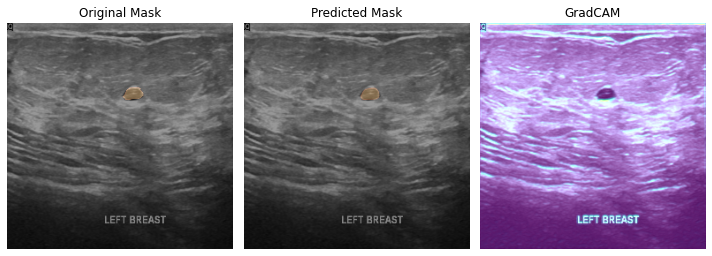

Epoch 72/150
97/97 [==============================] - 42s 432ms/step - loss: 0.0034 - accuracy: 0.9969 - IoU: 0.5262 - val_loss: 0.1323 - val_accuracy: 0.9821 - val_IoU: 0.5075
Epoch 73/150
97/97 [==============================] - 42s 431ms/step - loss: 0.0033 - accuracy: 0.9969 - IoU: 0.5400 - val_loss: 0.1321 - val_accuracy: 0.9834 - val_IoU: 0.5037
Epoch 74/150
97/97 [==============================] - 42s 431ms/step - loss: 0.0036 - accuracy: 0.9969 - IoU: 0.5290 - val_loss: 0.1241 - val_accuracy: 0.9839 - val_IoU: 0.5120
Epoch 75/150
97/97 [==============================] - 42s 431ms/step - loss: 0.0035 - accuracy: 0.9969 - IoU: 0.5203 - val_loss: 0.1272 - val_accuracy: 0.9834 - val_IoU: 0.5061
Epoch 76/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0034 - accuracy: 0.9969 - IoU: 0.5288 - val_loss: 0.1307 - val_accuracy: 0.9823 - val_IoU: 0.5118
Epoch 77/150
97/97 [==============================] - 42s 431ms/step - loss: 0.0033 - accuracy: 0.9970 - IoU: 0.547

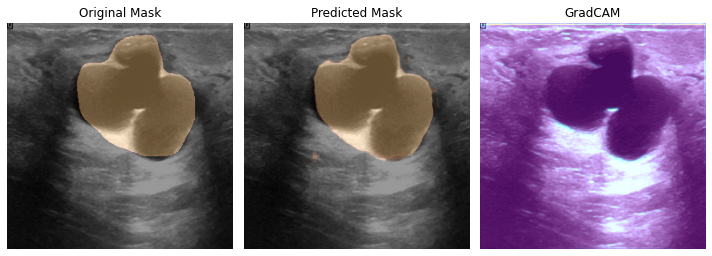

Epoch 82/150
97/97 [==============================] - 42s 434ms/step - loss: 0.0062 - accuracy: 0.9961 - IoU: 0.4849 - val_loss: 0.1540 - val_accuracy: 0.9681 - val_IoU: 0.4948
Epoch 83/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0742 - accuracy: 0.9718 - IoU: 0.4582 - val_loss: 0.1118 - val_accuracy: 0.9831 - val_IoU: 0.4909
Epoch 84/150
97/97 [==============================] - 42s 429ms/step - loss: 0.0325 - accuracy: 0.9862 - IoU: 0.4560 - val_loss: 0.1263 - val_accuracy: 0.9598 - val_IoU: 0.4934
Epoch 85/150
97/97 [==============================] - 42s 429ms/step - loss: 0.0177 - accuracy: 0.9918 - IoU: 0.4597 - val_loss: 0.0839 - val_accuracy: 0.9792 - val_IoU: 0.4909
Epoch 86/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0092 - accuracy: 0.9948 - IoU: 0.4612 - val_loss: 0.0917 - val_accuracy: 0.9849 - val_IoU: 0.4909
Epoch 87/150
97/97 [==============================] - 42s 429ms/step - loss: 0.0065 - accuracy: 0.9958 - IoU: 0.469

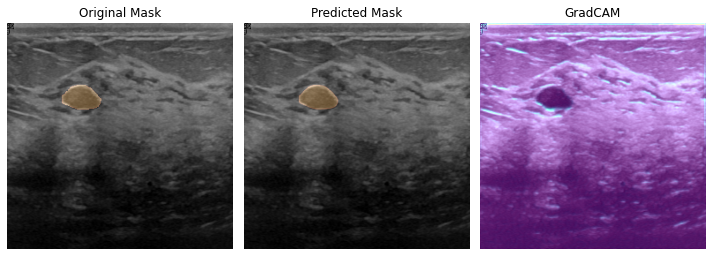

Epoch 92/150
97/97 [==============================] - 42s 429ms/step - loss: 0.0034 - accuracy: 0.9969 - IoU: 0.5891 - val_loss: 0.1219 - val_accuracy: 0.9822 - val_IoU: 0.5262
Epoch 93/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0035 - accuracy: 0.9968 - IoU: 0.5983 - val_loss: 0.1247 - val_accuracy: 0.9819 - val_IoU: 0.5306
Epoch 94/150
97/97 [==============================] - 42s 430ms/step - loss: 0.0031 - accuracy: 0.9970 - IoU: 0.6285 - val_loss: 0.1270 - val_accuracy: 0.9822 - val_IoU: 0.5292
Epoch 95/150
97/97 [==============================] - 42s 429ms/step - loss: 0.0031 - accuracy: 0.9970 - IoU: 0.6497 - val_loss: 0.1280 - val_accuracy: 0.9826 - val_IoU: 0.5383
Epoch 96/150
97/97 [==============================] - 42s 428ms/step - loss: 0.0031 - accuracy: 0.9970 - IoU: 0.6571 - val_loss: 0.1313 - val_accuracy: 0.9820 - val_IoU: 0.5371
Epoch 97/150
97/97 [==============================] - 42s 429ms/step - loss: 0.0030 - accuracy: 0.9970 - IoU: 0.666

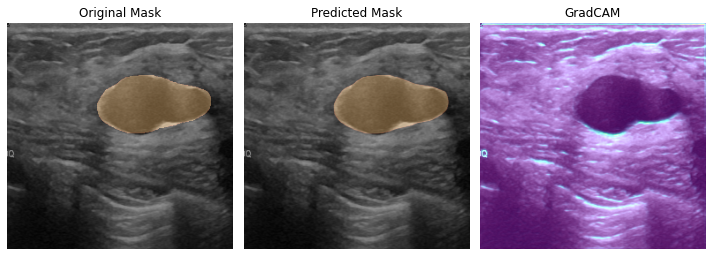

Epoch 102/150
97/97 [==============================] - 41s 428ms/step - loss: 0.0028 - accuracy: 0.9971 - IoU: 0.7184 - val_loss: 0.1338 - val_accuracy: 0.9832 - val_IoU: 0.5536
Epoch 103/150
97/97 [==============================] - 42s 429ms/step - loss: 0.0027 - accuracy: 0.9972 - IoU: 0.7262 - val_loss: 0.1391 - val_accuracy: 0.9824 - val_IoU: 0.5557
Epoch 104/150
97/97 [==============================] - 41s 428ms/step - loss: 0.0028 - accuracy: 0.9971 - IoU: 0.7367 - val_loss: 0.1355 - val_accuracy: 0.9829 - val_IoU: 0.5569
Epoch 105/150
97/97 [==============================] - 42s 429ms/step - loss: 0.0028 - accuracy: 0.9971 - IoU: 0.7320 - val_loss: 0.1367 - val_accuracy: 0.9828 - val_IoU: 0.5507
Epoch 106/150
97/97 [==============================] - 42s 428ms/step - loss: 0.0027 - accuracy: 0.9971 - IoU: 0.7227 - val_loss: 0.1386 - val_accuracy: 0.9827 - val_IoU: 0.5631
Epoch 107/150
97/97 [==============================] - 41s 428ms/step - loss: 0.0029 - accuracy: 0.9971 - IoU:

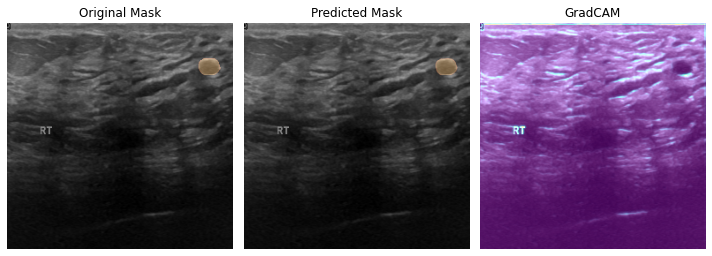

Epoch 112/150
97/97 [==============================] - 42s 428ms/step - loss: 0.0026 - accuracy: 0.9972 - IoU: 0.7407 - val_loss: 0.1402 - val_accuracy: 0.9823 - val_IoU: 0.5696
Epoch 113/150
97/97 [==============================] - 42s 429ms/step - loss: 0.0026 - accuracy: 0.9972 - IoU: 0.7505 - val_loss: 0.1373 - val_accuracy: 0.9840 - val_IoU: 0.5702
Epoch 114/150
97/97 [==============================] - 42s 429ms/step - loss: 0.0025 - accuracy: 0.9972 - IoU: 0.7744 - val_loss: 0.1367 - val_accuracy: 0.9840 - val_IoU: 0.5633
Epoch 115/150
97/97 [==============================] - 41s 428ms/step - loss: 0.0025 - accuracy: 0.9972 - IoU: 0.7479 - val_loss: 0.1350 - val_accuracy: 0.9837 - val_IoU: 0.5690
Epoch 116/150
97/97 [==============================] - 42s 428ms/step - loss: 0.0025 - accuracy: 0.9972 - IoU: 0.7648 - val_loss: 0.1375 - val_accuracy: 0.9840 - val_IoU: 0.5646
Epoch 117/150
97/97 [==============================] - 42s 429ms/step - loss: 0.0026 - accuracy: 0.9972 - IoU:

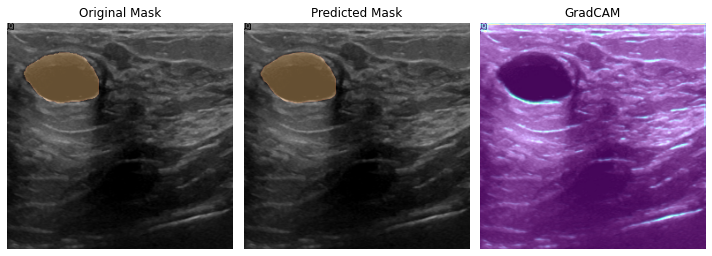

In [32]:
# Config Training
BATCH_SIZE = 8
SPE = len(images)//BATCH_SIZE
start_time=time.time()
# Training
results = model.fit(
    images, masks,
    validation_split=0.2,
    epochs=150, # 15 will be enough for a good Model for better model go with 20+
    steps_per_epoch=SPE,
    batch_size=BATCH_SIZE,
    callbacks=cb
)
end_time=time.time()

In [33]:
with open('model_architecture_UNET.json', 'w') as f:
    f.write(model.to_json())
    
model.save('Best_Model_ResAttUNET.h5')
model.save_weights('best_weights_raunet.h5')
#end_time - start_time

**Observations :**

* After **12 epochs** model started outputting what we needed.
* The model was easily able to detect **black round spots but fails when the shape is irregular**(Not the case with current model because it is trained with hight SPE). 

* It also gets confused between the dark areas, which makes sense.

---
**Suggestion :**
* Do training in chunks of **20 Epochs**, this will give you a good control **over model and the model will also perform well**.

* Here the model is trained on 17 + 17 + 17 = 51 Epochs.

* If you give the model a closer look n different images you will find that the model fails at some images, but I can garantee that 9/10 such images would be so tough that even a human will not be a able to detect as many parts of the image look the same.


# **Evaluation**

In [ ]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

Suprisingly the results on **Validation Data** are **way better** than the results on **Trainind Data** on **IoU**, this may indicate that the **model can perform way better** than what it can do at the current point. The **Loss is not Perfect** it increases in the last but the model constructions are loooking perfect as this point, that's why **I believe in what I see**. This model seems promising, let's try it on some Images.

In [ ]:
# saved_model = tf.keras.models.load_model('/kaggle/input/breast-cancer-detection-unet/BreastCancerAttentionUNet.h5')

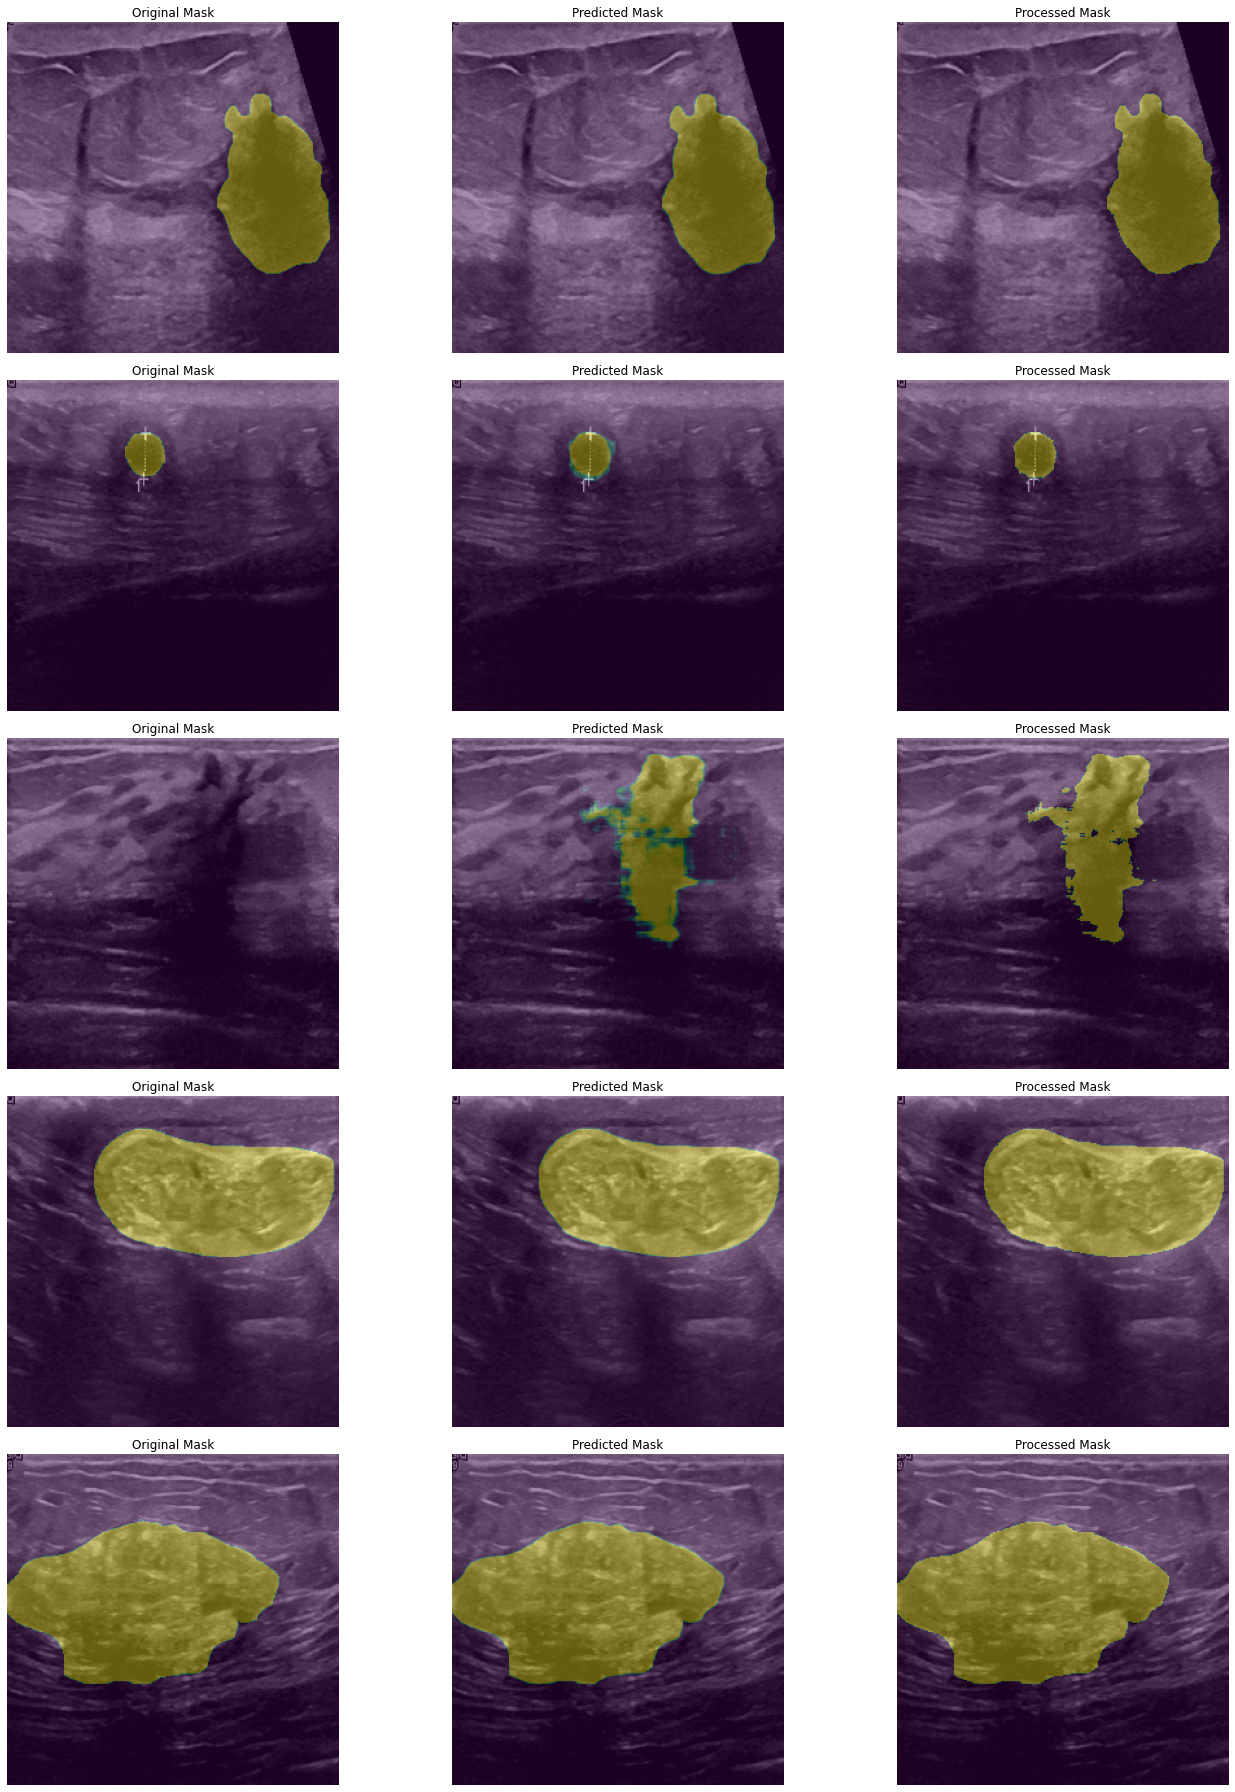

In [39]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])

        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()

The results totally convincing. If you have any suggestions please let me know 👍. **Thanks !!**